In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

In [2]:
url = 'https://archive.ics.uci.edu/static/public/45/data.csv'
df = pd.read_csv(url)

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### Missing Data
- 
Identifying Missing Dat- a
Dealing with Missing Data

In [8]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [10]:
# df['ca'].value_counts()
df['thal'].value_counts()    # both have category we can use median

thal
3.0    166
7.0    117
6.0     18
Name: count, dtype: int64

In [12]:
df['thal'] = df['thal'].fillna(df['thal'].median())
df['ca'] = df['ca'].fillna(df['ca'].median())
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

### Output or Target
 - it have 4 diffrent category 0 to 4, (i guss this is for the lavle of disease) need to convert into the binary for the better prediction (Disease/ No Disease)

In [14]:
df.rename(columns={"num": "output"}, inplace=True)
df['output'].value_counts()

output
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

In [16]:
df['output'] = df['output'].replace([1,2,3,4], 1)
df['output'].value_counts()

output
0    164
1    139
Name: count, dtype: int64

## Formatting the Data for Decision Trees

Splitting data into Dependent and Independent Variables
One-Hot-Encoding

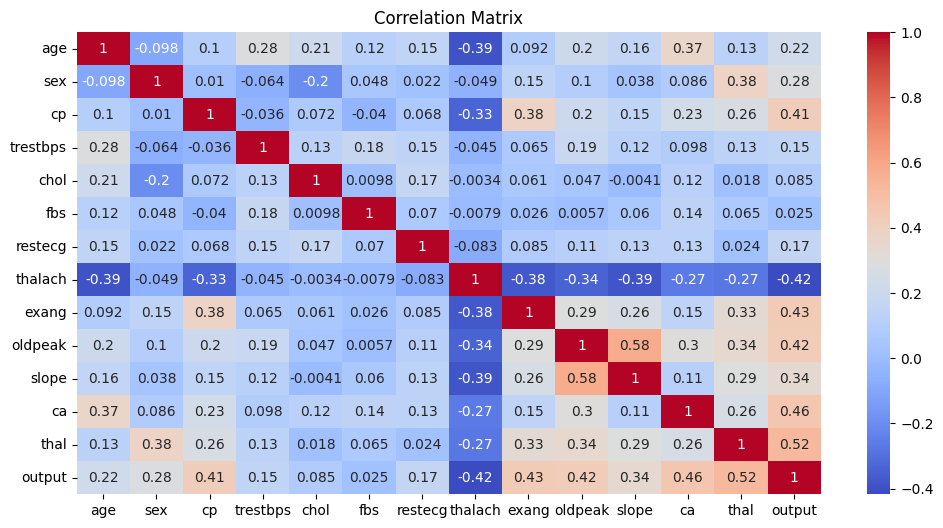

In [19]:
plt.figure(figsize=(12,6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [23]:
x = df.drop(['output',"fbs","chol"], axis=1)  # independent variables
y = df['output']                              # dependent variable

In [25]:
normalized_x = preprocessing.normalize(x)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)




## Building a Preliminary Classification Tree




In [75]:
# 1st 
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("1st Accuracy:", accuracy_score(y_test, y_pred))

1st Accuracy: 0.7377049180327869


In [77]:
# 2nd
model = DecisionTreeClassifier(
    max_depth=5,        
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("2nd Accuracy:", accuracy_score(y_test, y_pred))

2nd Accuracy: 0.7868852459016393


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79        29
           1       0.85      0.72      0.78        32

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.80      0.79      0.79        61



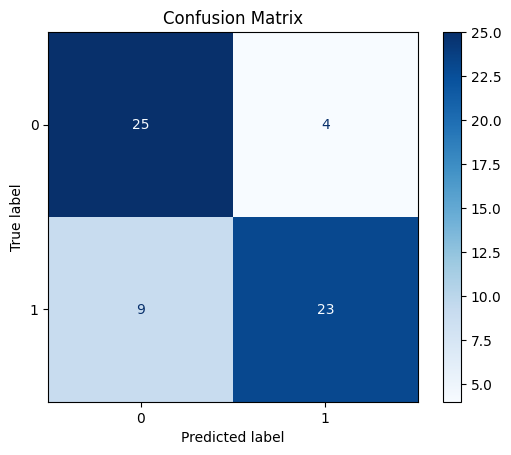

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [93]:
# from sklearn.tree import plot_tree
# plt.figure(figsize=(20, 10))
# plot_tree(model, filled=True, feature_names=x.columns, class_names=["No Disease", "Disease"])
# plt.show()

## Reduce Overfitting: Make the Tree Simpler

- **Pruning**  
  Reduce the size of the decision tree by removing sections that provide little power to classify instances.

- **Cross-Validation**  
  Evaluate the model on multiple subsets of the dataset to ensure it generalizes well to unseen data.
ion

In [89]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': np.arange(1,10,1),
    'min_samples_split': np.arange(2,10,1),
    'min_samples_leaf': np.arange(1,10,1)
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5,error_score='raise')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}
Best CV Score: 0.752295918367347


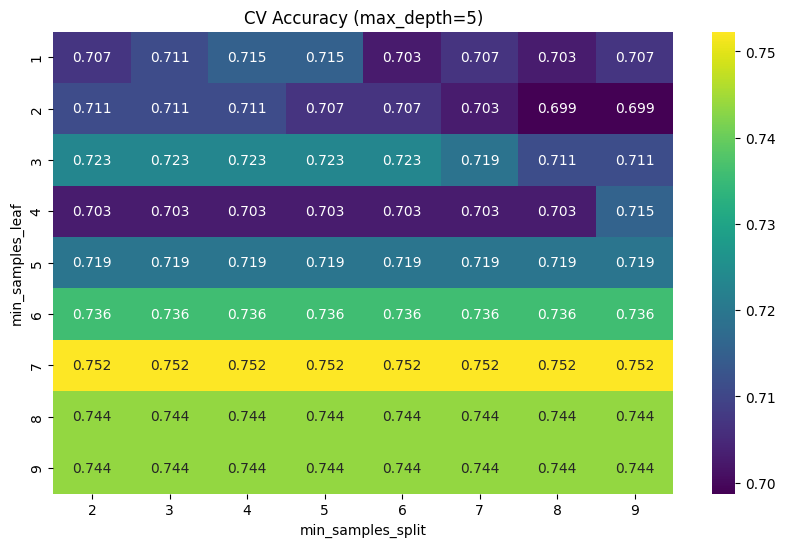

In [110]:
results = pd.DataFrame(grid.cv_results_)

# Filter for a specific max_depth, say 5
subset = results[results['param_max_depth'] == 5]

# Pivot table to get heatmap structure
pivot = subset.pivot(index='param_min_samples_leaf', 
                     columns='param_min_samples_split', 
                     values='mean_test_score')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
plt.title("CV Accuracy (max_depth=5)")
plt.xlabel("min_samples_split")
plt.ylabel("min_samples_leaf")
plt.show()

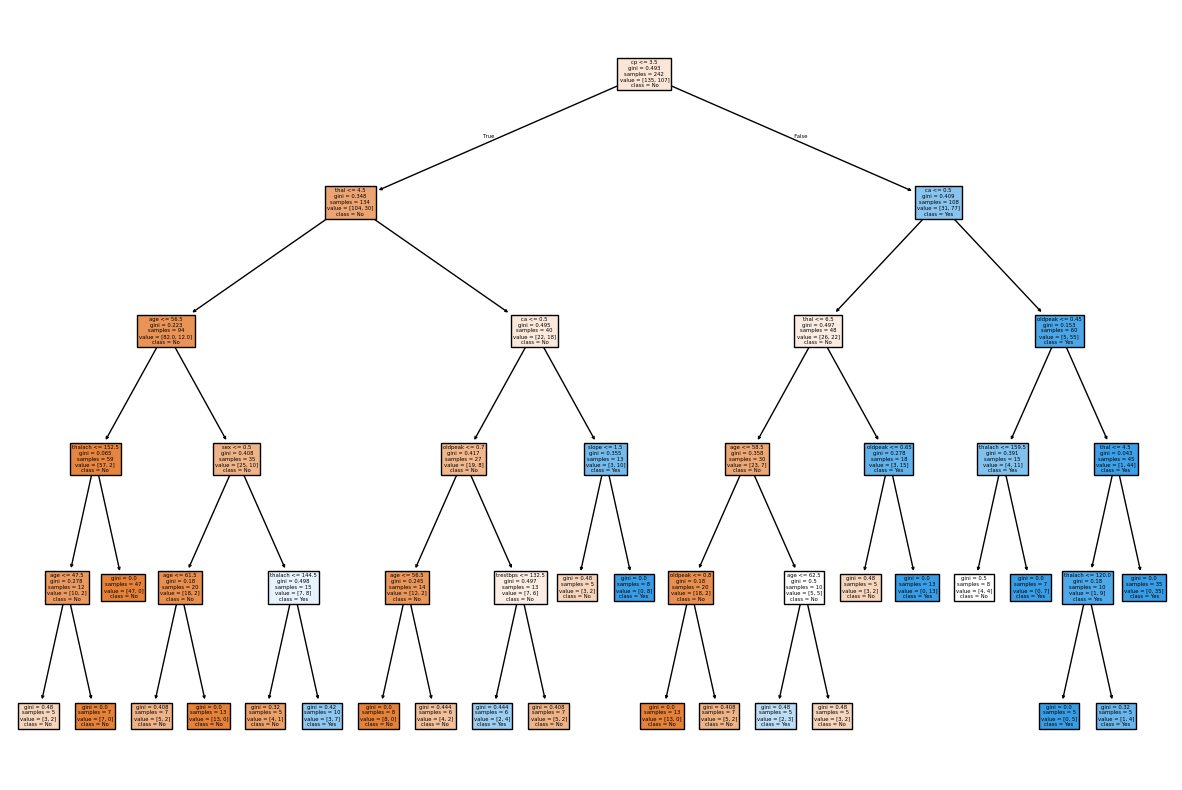

In [45]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plot_tree(model, filled=True, feature_names=x.columns, class_names=["No", "Yes"])
plt.show()

In [61]:
# Use best parameters to create final model
best_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=7,
    min_samples_split=2,
    random_state=42
)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print("Best Accuracy:", accuracy_score(y_test, y_pred_best))

Test Accuracy (Best Model): 0.819672131147541


In [63]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

[[24  5]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        29
           1       0.84      0.81      0.83        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



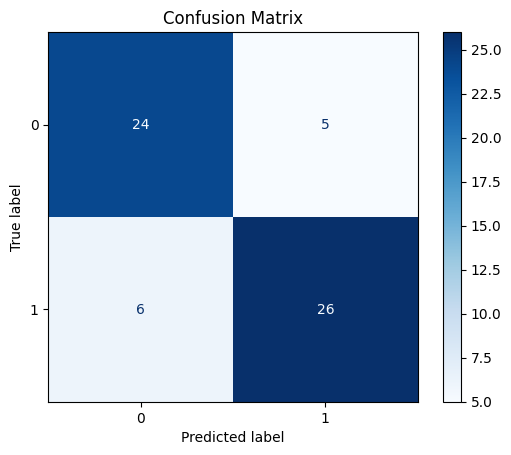

In [67]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_best))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()